# Replicating the M4 competition using sktime

Resources: 
* [Github repo of the M4 competition](https://github.com/M4Competition/M4-methods)

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy.stats import wilcoxon, binom_test
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from losses import smape_loss
from losses import mase_loss

%matplotlib inline

In [2]:
cmap = sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

### Set paths

In [3]:
repodir = "/Users/mloning/Documents/Research/python_methods/m4-methods/"
datadir = os.path.join(repodir, "Dataset")
traindir = os.path.join(datadir, 'Train')
testdir = os.path.join(datadir, 'Test')
resultsdir = os.path.join(repodir, "predictions")

assert os.path.exists(datadir)
assert os.path.exists(traindir)
assert os.path.exists(testdir)
assert os.path.exists(resultsdir)

### Load results from M4 competition for comparison

In [4]:
m4_results = pd.read_excel(os.path.join(repodir, 'Evaluation and Ranks.xlsx'), 
                        sheet_name='Point Forecasts-Frequency',
                        header=[0, 1]).dropna(axis=0)

original_mase_means = m4_results.loc[:, ['Method', 'MASE']]
original_mase_means.columns = original_mase_means.columns.droplevel()
original_mase_means = original_mase_means.set_index('User ID')

original_smape_means = m4_results.loc[:, ['Method', 'sMAPE']]
original_smape_means.columns = original_smape_means.columns.droplevel()
original_smape_means = original_smape_means.set_index('User ID')

In [5]:
strategies = m4_results.loc[:, ['Method', 'User ID']].iloc[:, 0]
baselines = [strategy for strategy in strategies if isinstance(strategy, str)]
print(baselines)

['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'Com', 'MLP', 'RNN']


In [6]:
selected_baselines = ['Naive', 'Naive2', 'SES', 'Holt', 'Damped']

In [7]:
original_smape_means = original_smape_means.loc[selected_baselines, :].sort_index().drop(columns='Total')
original_smape_means.index.name = None

original_mase_means = original_mase_means.loc[selected_baselines, :].sort_index().drop(columns='Total')
original_mase_means.index.name = None

print(original_mase_means.shape, original_smape_means.shape)

(5, 6) (5, 6)


### Import meta data

In [8]:
import pandas as pd
info = pd.read_csv(os.path.join(datadir, 'M4-info.csv'))

In [9]:
info.head()

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00


In [10]:
n_datasets = info.shape[0]
print(n_datasets)

100000


In [11]:
info.category.value_counts()

Micro          25121
Finance        24534
Macro          19402
Industry       18798
Demographic     8708
Other           3437
Name: category, dtype: int64

In [12]:
n_series = info.SP.value_counts().to_dict()
n_series

{'Monthly': 48000,
 'Quarterly': 24000,
 'Yearly': 23000,
 'Daily': 4227,
 'Hourly': 414,
 'Weekly': 359}

In [13]:
# dictionary of forecasting horizons
fhs = info.set_index('SP').Horizon.to_dict()
fhs

{'Yearly': 6,
 'Quarterly': 8,
 'Monthly': 18,
 'Weekly': 13,
 'Daily': 14,
 'Hourly': 48}

In [14]:
# dictionary of frequencies
sps = info.set_index('SP').Frequency.to_dict()
sps

{'Yearly': 1,
 'Quarterly': 4,
 'Monthly': 12,
 'Weekly': 1,
 'Daily': 1,
 'Hourly': 24}

In [15]:
# look up individual time series
info.loc[info.loc[:, 'M4id'] == 'M4', :]

,M4id,category,Frequency,Horizon,SP,StartingDate
47003,M4,Macro,12,18,Monthly,01-09-08 12:00


In [16]:
files = os.listdir(traindir)
files

['Weekly-train.csv',
 'Daily-train.csv',
 'Hourly-train.csv',
 'Monthly-train.csv',
 'Yearly-train.csv',
 'Quarterly-train.csv']

In [17]:
datasets = [f.split('-')[0] for f in files]
datasets

['Weekly', 'Daily', 'Hourly', 'Monthly', 'Yearly', 'Quarterly']

In [18]:
[dataset[0] for dataset in datasets]

['W', 'D', 'H', 'M', 'Y', 'Q']

### Load training data files

In [17]:
sl = []
for dataset in datasets:
    alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'),
                           index_col=0)
    sl.append(alltrain.notna().sum(axis=1).describe())

series_lengths = pd.concat(sl, axis=1).T
series_lengths.index = datasets
series_lengths['total_n_obs'] = series_lengths['count'] * series_lengths['mean']
series_lengths['fh'] = pd.Series(fhs)
series_lengths.sort_values('total_n_obs', ascending=False)

,count,mean,std,min,25%,50%,75%,max,total_n_obs,fh
Monthly,48000.0,216.300229,137.406295,42.0,82.0,202.0,306.0,2794.0,10382411.0,18
Daily,4227.0,2357.383014,1756.568917,93.0,323.0,2940.0,4197.0,9919.0,9964658.0,14
Quarterly,24000.0,92.254500,51.129507,16.0,62.0,88.0,115.0,866.0,2214108.0,8
Yearly,23000.0,31.324261,24.523966,13.0,20.0,29.0,40.0,835.0,720458.0,6
Weekly,359.0,1022.038997,707.148455,80.0,379.0,934.0,1603.0,2597.0,366912.0,13
Hourly,414.0,853.864734,127.945362,700.0,700.0,960.0,960.0,960.0,353500.0,48


### Compute scores

In [18]:
selected_datasets = datasets

replicated_mase_means = dict()
replicated_smape_means = dict()

# for each dataset
for dataset in selected_datasets:
    sp = sps[dataset]
    fh = fhs[dataset]
    n = n_series[dataset]

    replicated_mase_means[dataset] = dict()
    replicated_smape_means[dataset] = dict()

    # sort index as done during benchmarking
    alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'), index_col=0).sort_index()
    alltest = pd.read_csv(os.path.join(testdir, f'{dataset}-test.csv'), index_col=0).sort_index()

    # for each strategy
    for strategy in selected_baselines:
        
        # load replicated forecasts
        file = os.path.join(resultsdir, strategy, f'{strategy}_{dataset}_forecasts.txt')
        y_preds = np.loadtxt(file)
        assert y_preds.shape == (n, fh)

        # for each series
        mases = np.zeros(n)
        smapes = np.zeros(n)
        for i in range(n):
            
            # select series
            y_train = alltrain.iloc[i, :].dropna().reset_index(drop=True).values
            y_test = alltest.iloc[i, :].dropna().reset_index(drop=True).values
            y_pred = y_preds[i, :]
            assert y_test.shape == y_pred.shape
            
            # compute losses on each series
            mases[i] = mase_loss(y_test, y_pred, y_train, sp=sp)
            smapes[i] = smape_loss(y_test, y_pred)
            
        # average losses over series for each dataset
        replicated_mase_means[dataset][strategy] = np.nanmean(mases)
        replicated_smape_means[dataset][strategy] = np.nanmean(smapes)

In [22]:
# save calculated errors
replicated_mase_means = pd.DataFrame(replicated_mase_means)
replicated_smape_means = pd.DataFrame(replicated_smape_means)

replicated_mase_means.to_csv(os.path.join(resultsdir, 'replicated_mase_means.csv'))
replicated_smape_means.to_csv(os.path.join(resultsdir, 'replicated_smape_means.csv'))

### Compare results

In [18]:
def percentage_difference(x, y):
    return (x - y) / x * 100

In [19]:
# reload saved results
replicated_mase_means = pd.read_csv(os.path.join(resultsdir, 'replicated_mase_means.csv'), index_col=0)
replicated_smape_means = pd.read_csv(os.path.join(resultsdir, 'replicated_smape_means.csv'), index_col=0)

In [23]:
replicated_smape_means = pd.DataFrame(replicated_smape_means).round(3).sort_index()
replicated_smape_means = replicated_smape_means.loc[:, ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']]

percdiff_smape = percentage_difference(original_smape_means, replicated_smape_means.round(3)).round(3)

In [24]:
replicated_mase_means = pd.DataFrame(replicated_mase_means).round(3).sort_index()
replicated_mase_means = replicated_mase_means.loc[:, ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']]

percdiff_mase = percentage_difference(original_mase_means, replicated_mase_means.round(3)).round(3)

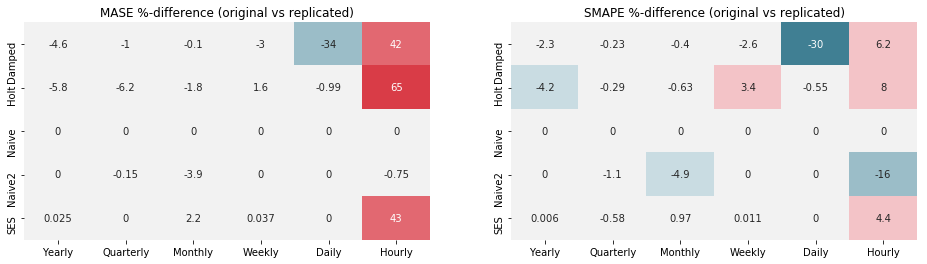

In [25]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=plt.figaspect(.25))
g = sns.heatmap(percdiff_mase, annot=True, cmap=cmap, center=0, cbar=False, ax=ax0)
g.set(title='MASE %-difference (original vs replicated)')
g = sns.heatmap(percdiff_smape, annot=True, cmap=cmap, center=0, cbar=False, ax=ax1)
g.set(title='SMAPE %-difference (original vs replicated)');

* lower MASE or SMAPE is better
* negative difference means replicated error is worse than original one

### Look into deviations

In [19]:
def compute_wilcoxon(x, y):
    return wilcoxon(x, y).pvalue

def compute_binomial(x, y):
    x_wins = x > y
    y_wins = y > x
    draw = x == y
    p_bin = binom_test(np.sum(x_wins), n=x.shape[0], p=0.5, alternative='two-sided')
    return p_bin

In [20]:
def compare_scores(x, y, title=None, xlabel=None, ylabel=None, ax=None):
    """Helper function to compare scores visually and statistically 
    using the Wilcoxon signed rank test and binomial test
    """
    
    if ax is None:
        fig, ax = plt.subplots(1)
    
    p_wil = compute_wilcoxon(x, y)
    p_bin = compute_binomial(x, y)
    
    title = f"{title} \nwilcoxon pval: {np.round(p_wil, 4)} \nbinomial pval: {np.round(p_bin, 4)}"
    
    max_ax = np.max([np.nanmax(x), np.nanmax(y)])
    ax.scatter(x, y)
    ax.plot([0, max_ax], [0, max_ax], 'red', linewidth=1)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return ax

In [21]:
def compute_scores(strategy, dataset):
    sp = sps[dataset]

    n_fh = fhs[dataset]
    fh = np.arange(n_fh) + 1

    n = n_series[dataset]

    file = os.path.join(resultsdir, strategy, f'{strategy}_{dataset}_forecasts.txt')
    y_preds = np.loadtxt(file)
    assert y_preds.shape == (n, n_fh)

    alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'), index_col=0).sort_index()
    alltest = pd.read_csv(os.path.join(testdir, f'{dataset}-test.csv'), index_col=0).sort_index()
    assert alltest.shape == y_preds.shape
    
    y_preds_original = pd.read_csv(os.path.join(repodir, 'Point Forecasts', f'submission-{strategy}.csv'))
    y_preds_original = (y_preds_original
                        .loc[y_preds_original.id.str.startswith(dataset[0]), :]
                        .set_index('id')
                        .sort_index()
                        .dropna(axis=1)
                        .values)
    assert y_preds_original.shape == y_preds.shape
    
    replicated_mases = np.zeros(n)
    replicated_smapes = np.zeros(n)

    original_mases = np.zeros(n)
    original_smapes = np.zeros(n)

    for i in range(n):
        y_train = alltrain.iloc[i, :].dropna().values
        y_test = alltest.iloc[i, :].dropna().values
        y_pred = y_preds[i, :]
        y_pred_original = y_preds_original[i, :]
        assert y_test.shape == y_pred.shape

        replicated_mases[i] = mase_loss(y_test, y_pred, y_train, sp=sp)
        replicated_smapes[i] = smape_loss(y_test, y_pred)

        original_mases[i] = mase_loss(y_test, y_pred_original, y_train, sp=sp)
        original_smapes[i] = smape_loss(y_test, y_pred_original)
    
    return replicated_mases, replicated_smapes, original_mases, original_smapes

In [99]:
strategy = 'Damped'
dataset = 'Daily'

In [100]:
replicated_mases, replicated_smapes, original_mases, original_smapes = compute_scores(strategy, dataset)

assert np.nanmean(replicated_mases).round(3) == replicated_mase_means.loc[strategy, dataset]
assert np.nanmean(replicated_smapes).round(3) == replicated_smape_means.loc[strategy, dataset]
assert np.nanmean(original_mases).round(3) == original_mase_means.loc[strategy, dataset]
assert np.nanmean(original_smapes).round(3) == original_smape_means.loc[strategy, dataset]

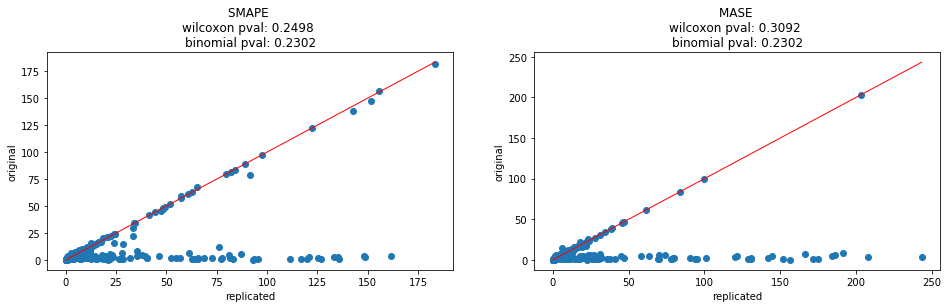

In [102]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=plt.figaspect(.25))
compare_scores(replicated_smapes, original_smapes, 
               xlabel='replicated', ylabel='original', title='SMAPE', 
               ax=ax0)
compare_scores(replicated_mases, original_mases,
               xlabel='replicated', ylabel='original', title='MASE', 
               ax=ax1);

* If the Wilcoxon p-value is less than 0.05, the observed difference between both measurements is significant 
* If the binomial p-value is less than 0.05, the null hypothesis that one scores from one set are larger than scores from the other set can be rejected, i.e. they are likely to come from the same distribution.

### Rerun on specific series

In [170]:
# sort index as done during benchmarking
alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'), index_col=0).sort_index()
alltest = pd.read_csv(os.path.join(testdir, f'{dataset}-test.csv'), index_col=0).sort_index()

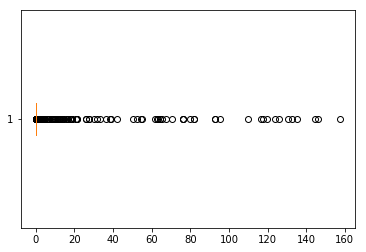

In [182]:
abs_diff = np.abs(replicated_smapes - original_smapes)
plt.boxplot(abs_diff, vert=False);

In [183]:
sorted_index = np.argsort(abs_diff)
assert sorted_index[-1] == np.argmax(abs_diff)

In [232]:
idx = sorted_index[-5]

In [233]:
series_id = alltrain.iloc[idx].name
series_id

'D3500'

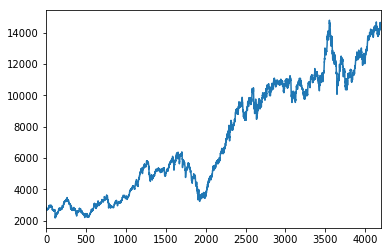

In [234]:
y_train = alltrain.loc[series_id].dropna().reset_index(drop=True)
y_train.plot();

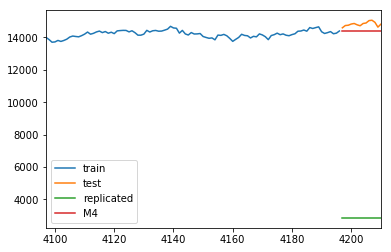

In [241]:
y_test = alltest.loc[series_id].dropna().reset_index(drop=True)
y_test.index = y_test.index + y_train.shape[0]

y_preds_original = pd.read_csv(os.path.join(repodir, 'Point Forecasts', f'submission-{strategy}.csv'), index_col=0)
y_pred_original = y_preds_original.loc[series_id].reset_index(drop=True).dropna()
y_pred_original.index = y_pred_original.index + y_train.shape[0]

# fit/forecast
fh = fhs[dataset]
from statsmodels.tsa.holtwinters import ExponentialSmoothing
m = ExponentialSmoothing(y_train, trend='add', damped=True)
mf = m.fit(use_basinhopping=True)
y_pred = mf.forecast(fh)

# plot
fig, ax = plt.subplots(1)
y_train.iloc[-100:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='replicated')
y_pred_original.plot(ax=ax, label='M4');
plt.legend();

In [237]:
mase = smape_loss(y_test, y_pred)
mase

135.2773423926527

In [238]:
assert y_train.iloc[0] == mf._results.params['initial_level']

In [178]:
mf._results.params

{'smoothing_level': 0.0,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': 0.7368421052631579,
 'initial_level': 2153.0,
 'initial_slope': 0.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

* what goes wrong is the slope estimation, while the damping slope parameter is fitted, the trend/slope is not properly estimated and falls back to zero, with the first value of the training set as the level value

### Compute p-values

In [24]:
datasets

['Weekly', 'Daily', 'Hourly', 'Monthly', 'Yearly', 'Quarterly']

In [25]:
smape_binomial = np.zeros((len(selected_baselines), len(datasets)))
mase_binomial = np.zeros((len(selected_baselines), len(datasets)))

smape_wilcoxon = np.zeros((len(selected_baselines), len(datasets)))
mase_wilcoxon = np.zeros((len(selected_baselines), len(datasets)))


for i, strategy in enumerate(selected_baselines):
    for j, dataset in enumerate(datasets):
        replicated_mases, replicated_smapes, original_mases, original_smapes = compute_scores(strategy, dataset)
        
        smape_binomial[i, j] = compute_binomial(replicated_smapes, original_smapes)
        mase_binomial[i, j] = compute_binomial(replicated_mases, original_mases)
        
        smape_wilcoxon[i, j] = compute_wilcoxon(replicated_smapes, original_smapes)
        mase_wilcoxon[i, j] = compute_wilcoxon(replicated_mases, original_mases)

/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/scipy/stats/morestats.py:2803: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/scipy/stats/morestats.py:2803: Runt

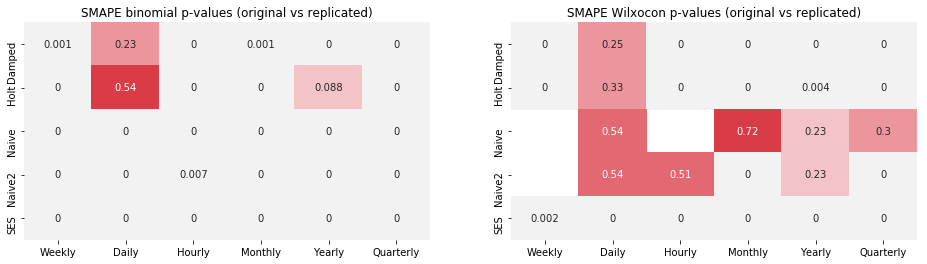

In [32]:
smape_binomial = pd.DataFrame(smape_binomial, index=selected_baselines, columns=datasets).round(3).sort_index()
smape_wilcoxon = pd.DataFrame(smape_wilcoxon, index=selected_baselines, columns=datasets).round(3).sort_index()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=plt.figaspect(.25))
g = sns.heatmap(smape_binomial, annot=True, cmap=cmap, center=0, cbar=False, ax=ax0)
g.set(title='SMAPE binomial p-values (original vs replicated)')
g = sns.heatmap(smape_wilcoxon, annot=True, cmap=cmap, center=0, cbar=False, ax=ax1)
g.set(title='SMAPE Wilxocon p-values (original vs replicated)');

### Replicate errors on specific series

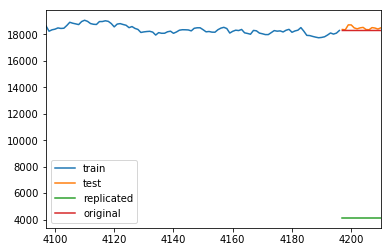

In [144]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# set paths
repodir = "/Users/mloning/Documents/Research/python_methods/m4-methods/"
datadir = os.path.join(repodir, "Dataset")
traindir = os.path.join(datadir, 'Train')
testdir = os.path.join(datadir, 'Test')

# select dataset/series
dataset = 'Daily'
series_id = dataset[0] + str(703)

# load data
alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'), index_col=0)
alltest = pd.read_csv(os.path.join(testdir, f'{dataset}-test.csv'), index_col=0)

y_train = alltrain.loc[series_id].dropna().reset_index(drop=True)

y_test = alltest.loc[series_id].dropna().reset_index(drop=True)
y_test.index = y_test.index + y_train.shape[0]

y_preds_original = pd.read_csv(os.path.join(repodir, 'Point Forecasts', 'submission-Damped.csv'), index_col=0)
y_pred_original = y_preds_original.loc[series_id].reset_index(drop=True).dropna()
y_pred_original.index = y_pred_original.index + y_train.shape[0]

# fit/forecast
m = ExponentialSmoothing(y_train, trend='add', damped=True)
mf = m.fit()
y_pred = mf.forecast(14)

# plot
fig, ax = plt.subplots(1)
y_train.iloc[-100:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='replicated')
y_pred_original.plot(ax=ax, label='original');
plt.legend();

In [ ]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# set paths
repodir = "/Users/mloning/Documents/Research/python_methods/m4-methods/"
datadir = os.path.join(repodir, "Dataset")
traindir = os.path.join(datadir, 'Train')
testdir = os.path.join(datadir, 'Test')

# select dataset/series
dataset = 'Daily'
series_id = dataset[0] + str(703)

# load data
alltrain = pd.read_csv(os.path.join(traindir, f'{dataset}-train.csv'), index_col=0)
alltest = pd.read_csv(os.path.join(testdir, f'{dataset}-test.csv'), index_col=0)

y_train = alltrain.loc[series_id].dropna().reset_index(drop=True)

y_test = alltest.loc[series_id].dropna().reset_index(drop=True)
y_test.index = y_test.index + y_train.shape[0]

y_preds_original = pd.read_csv(os.path.join(repodir, 'Point Forecasts', 'submission-Damped.csv'), index_col=0)
y_pred_original = y_preds_original.loc[series_id].reset_index(drop=True).dropna()
y_pred_original.index = y_pred_original.index + y_train.shape[0]

# fit/forecast
m = ExponentialSmoothing(y_train, trend='add', damped=True)
mfd = m.fit()
y_pred_d = mfd.forecast(14)

m = ExponentialSmoothing(y_train, trend='add', damped=False)
mfu = m.fit()
y_pred_u = mfu.forecast(14)

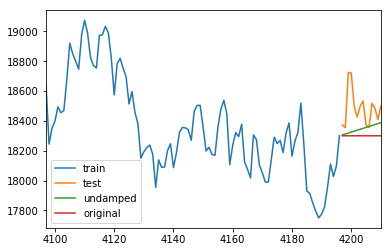

In [178]:
# plot
fig, ax = plt.subplots(1)
y_train.iloc[-100:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
#y_pred_d.plot(ax=ax, label='damped')
y_pred_u.plot(ax=ax, label='undamped')
y_pred_original.plot(ax=ax, label='original');
plt.legend();

In [182]:
y_train.iloc[-1]

18301.1

initial_level
smoothing_slope
initial_slope

In [180]:
mfu._results.__dict__[]

{'data': <statsmodels.base.data.PandasData at 0x7ffb10421710>,
 'fittedfcast': array([ 4127.48893983,  4128.53497602,  4094.39498384, ...,
        18034.2099253 , 18105.0033864 , 18305.80259685]),
 'fittedvalues': array([ 4127.48893983,  4128.53497602,  4094.39498384, ...,
        18115.9295566 , 18034.2099253 , 18105.0033864 ]),
 'fcastvalues': array([18305.80259685]),
 'sse': 30842386.372629553,
 'level': array([ 4127.69826273,  4093.59002396,  3957.13914823, ...,
        18028.12869901, 18098.86341149, 18299.48590168]),
 'slope': array([0.83671328, 0.80495988, 0.68023974, ..., 6.08122628, 6.13997491,
        6.31669517]),
 'season': array([0., 0., 0., ..., 0., 0., 0.]),
 'aic': 37370.84909611828,
 'bic': 37396.21759717162,
 'aicc': 37370.86914385098,
 'resid': array([   0.21106017,  -35.23497602, -138.39498384, ...,  -88.5295566 ,
          65.1900747 ,  196.0966136 ]),
 'k': 4,
 'params': {'smoothing_level': 0.9917688618279866,
  'smoothing_slope': 0.0009086691329995814,
  'smoothi

In [181]:
mfd._results.__dict__

{'data': <statsmodels.base.data.PandasData at 0x7ffb10421978>,
 'fittedfcast': array([4127.7, 4127.7, 4127.7, ..., 4127.7, 4127.7, 4127.7]),
 'fittedvalues': array([4127.7, 4127.7, 4127.7, ..., 4127.7, 4127.7, 4127.7]),
 'fcastvalues': array([4127.7]),
 'sse': 121510574038.16998,
 'level': array([4127.7, 4127.7, 4127.7, ..., 4127.7, 4127.7, 4127.7]),
 'slope': array([0., 0., 0., ..., 0., 0., 0.]),
 'season': array([0., 0., 0., ..., 0., 0., 0.]),
 'aic': 72119.2523936697,
 'bic': 72150.96301998636,
 'aicc': 72119.27913036103,
 'resid': array([    0. ,   -34.4,  -171.7, ..., 13899.7, 13971.7, 14173.4]),
 'k': 5,
 'params': {'smoothing_level': 0.0,
  'smoothing_slope': 0.0,
  'smoothing_seasonal': nan,
  'damping_slope': 0.7368421052631579,
  'initial_level': 4127.7,
  'initial_slope': 0.0,
  'initial_seasons': array([], dtype=float64),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 'model': <statsmodels.tsa.holtwinters.ExponentialSmoothing at 0x7ffb104218d0>,
 'k_const

### Trend is not updated properly?

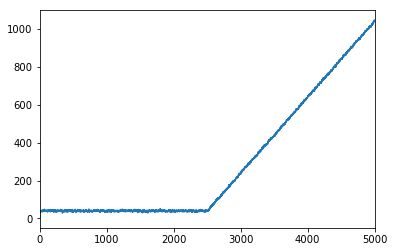

In [173]:
# generate data
rng = np.random.RandomState(1)
n = 5000
mu = 10
sd = 2
y = np.zeros(n)
y[0] = 3
alpha = .75
beta = 0.1
for i in range(1, n // 2):
    y[i] = (alpha * y[i - 1]) + rng.normal(loc=mu, scale=sd)
for i in range(n // 2, n):
    y[i] = (alpha * y[i - 1]) + (beta * (i - (n // 2))) + rng.normal(loc=mu, scale=sd)
    
y = pd.Series(y)
y.plot()

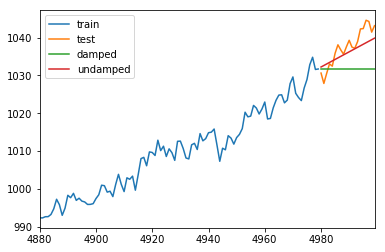

In [174]:
# split into train/test
fh = 20 # forecast horizon
y_train = pd.Series(y[:-fh])
y_test = pd.Series(y[-fh:])

# fit/forecast
m = ExponentialSmoothing(y_train, trend='add', damped=False)
mfu = m.fit()
y_undamped = mfu.forecast(fh)

m = ExponentialSmoothing(y_train, trend='add', damped=True)
mfd = m.fit()
y_damped = mfd.forecast(fh)

# plot
fig, ax = plt.subplots(1)
y_train.iloc[-100:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_damped.plot(ax=ax, label='damped')
y_undamped.plot(ax=ax, label='undamped')
plt.legend();

### Damping does not seem to work properly?

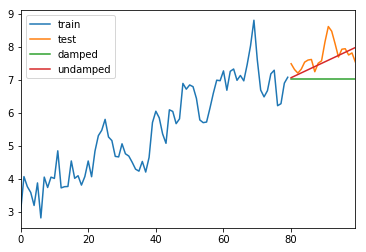

In [142]:
# generate data
rng = np.random.RandomState(1)
n = 100
y = np.zeros(n)
y[0] = 3
alpha = .75
beta = 0.01
for i in range(1, n):
    y[i] = (alpha * y[i - 1]) + (beta * i) + rng.normal(loc=1, scale=0.5)
y = pd.Series(y)

# split into train/test
fh = 20 # forecast horizon
y_train = pd.Series(y[:-fh])
y_test = pd.Series(y[-fh:])

# fit/forecast
m = ExponentialSmoothing(y_train, trend='add', damped=False)
mf = m.fit()
y_undamped = mf.forecast(fh)

m = ExponentialSmoothing(y_train, trend='add', damped=True)
mf = m.fit()
y_damped = mf.forecast(fh)

# plot
fig, ax = plt.subplots(1)
y_train.iloc[-100:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_damped.plot(ax=ax, label='damped')
y_undamped.plot(ax=ax, label='undamped')
plt.legend();